In [1]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Parameters
C = 1*ufarad
gl = 0.3*msiemens

El = -59.387*mV
EK = -82*mV
ENa = 45*mV

g_na = 120*msiemens  # (100*msiemens*cm**-2) * area
g_k = 36*msiemens #(3*msiemens*cm**-2) * area
VT = -70*mV

Kp = 5 * mV
Vp = 7 * mV

E = -38*mV 
alpha_r_glu = 2.4 / (mM * ms)
beta_r_glu = 0.56 * ms**-1
T_max_glu = 1.0 * mM

ECl = - 80 * mV
alpha_r_gaba = 5 / (mM * ms)
beta_r_gaba = 0.18 * ms**-1
T_max_gaba = 1.5 * mM

In [3]:
base_equations = ('''
dv/dt = (-gl*(v-El)
         -g_na*m**3*h*(v-ENa)
         -g_k*n**4*(v-EK) - I_syn_glu - I_syn_gaba + I_e)/C : volt
dm/dt = alpha_m*(1-m)-beta_m*m : 1
dn/dt = alpha_n*(1-n)-beta_n*n : 1
dh/dt = alpha_h*(1-h)-beta_h*h : 1
alpha_m = 0.1*(mV**-1) * (v + 45*mV) / (1 - exp(-(v + 45*mV) / (10*mV))) / ms : Hz
beta_m = 4 * exp(-(v + 70 * mV) / (18 * mV)) / ms: Hz
alpha_h = 0.07 * exp(-(v + 70*mV) / (20 * mV)) / ms: Hz
beta_h = 1 /(1 + exp((-(v + 40*mV))/(10*mV))) / ms: Hz
alpha_n = 0.01*(mV**-1) * (v + 60*mV) / (1 - exp(-(v + 60*mV)/(10*mV))) / ms: Hz
beta_n = 0.125 * exp(- (v + 70*mV) / (80*mV)) / ms: Hz

# These are for the outgoing excitatory synapses on the neuron
dr_glu/dt = alpha_r_glu * T_glu * (1-r_glu) - beta_r_glu * r_glu : 1
T_glu = T_max_glu / (1 + exp(-(v - Vp)/Kp)) : mM
I_syn_glu = (g_glu * (r_glu1_tot + r_glu2_tot) * (v - E)) : amp

# These are for the outgoing inhibitory synapses on the neuron
dr_gaba/dt = alpha_r_gaba * T_gaba * (1-r_gaba) - beta_r_gaba * r_gaba : 1
T_gaba = T_max_gaba / (1 + exp(-(v - Vp)/Kp)) : mM
I_syn_gaba = (g_gaba * r_gaba_tot * (v - ECl)) : amp
''')

EC2_eqs = Equations(base_equations + '''
I_e : amp #input_current(t, i) : amp
g_glu : siemens
r_glu1_tot = 0 : 1
r_glu2_tot = 0 : 1
r_gaba_tot = 0 : 1
''')

DG_eqs = Equations(base_equations + '''
I_e = 0*amp: amp
g_glu : siemens
r_glu1_tot : 1
r_glu2_tot = 0 : 1
r_gaba_tot = 0 : 1
''')

CA1_eqs = Equations(base_equations + '''
I_e = 0*amp : amp
g_glu : siemens
g_gaba : siemens
r_glu1_tot : 1
r_glu2_tot : 1
r_gaba_tot = 0 : 1
''')

CA3_eqs = Equations(base_equations + '''
I_e = 0*amp : amp
g_glu : siemens
r_glu1_tot : 1
r_glu2_tot : 1
r_gaba_tot : 1
''')

excitatory_eqs_1 = Equations('''
r_glu1_tot_post = r_glu_pre : 1 (summed)
''')

excitatory_eqs_2 = Equations('''
r_glu2_tot_post = r_glu_pre : 1 (summed)
''')

inhibitory_eqs = Equations('''
r_gaba_tot_post = r_gaba_pre : 1 (summed)
''')

In [4]:
EC2 = NeuronGroup(5, model=EC2_eqs, threshold='v>-20*mV', method='exponential_euler')
DG = NeuronGroup(5, model=DG_eqs, threshold='v>-20*mV', method='exponential_euler')
CA3 = NeuronGroup(5, model=CA3_eqs, threshold='v>-20*mV', method='exponential_euler')
CA1 = NeuronGroup(5, model=CA1_eqs, threshold='v>-20*mV', method='exponential_euler')

EC2.I_e = 10 * uA
g_gaba = 0.0005 * siemens
g_glu = 0.0005 * siemens

CA1.g_gaba = 'g_gaba + (randn()/100000 * siemens)'
EC2.g_glu = 'g_glu + (randn()/2000 * siemens)'
DG.g_glu = 'g_glu + (randn()/2000 * siemens)'
CA1.g_glu = 'g_glu + (randn()/2000 * siemens)'
CA3.g_glu = 'g_glu + (randn()/2000 * siemens)'

EC2_to_DG = Synapses(EC2, DG, model=excitatory_eqs_1)
EC2_to_CA1 = Synapses(EC2, CA1, model=excitatory_eqs_1)
EC2_to_CA3 = Synapses(EC2, CA3, model=excitatory_eqs_1)
DG_to_CA3 = Synapses(DG, CA3, model=excitatory_eqs_2)
CA3_to_CA1 = Synapses(CA3, CA1, model=excitatory_eqs_2)
CA1_to_CA3 = Synapses(CA1, CA3, model=inhibitory_eqs)

z = np.arange(5)
np.random.shuffle(z)
x = np.arange(5)
np.random.shuffle(x)
EC2_to_DG.connect(p=1, i = z, j = x)
EC2_to_CA3.connect(p=1, i = x, j = z)
EC2_to_CA1.connect(p=1, i = z, j = x)
DG_to_CA3.connect(p=1, i = x, j = z)
CA3_to_CA1.connect(p=1, i = z, j = x)
CA1_to_CA3.connect(p=1, i = x, j = z)

# Initialization
EC2.v = 'VT'
DG.v = 'VT' 
CA1.v = 'VT'
CA3.v = 'VT' 

WARNING    "g_gaba" is an internal variable of group "neurongroup_3", but also exists in the run namespace with the value 0.5 * msiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "g_glu" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 0.5 * msiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "g_glu" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 0.5 * msiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "g_glu" is an internal variable of group "neurongroup_3", but also exists in the run namespace with the value 0.5 * msiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "g_glu" is an internal variable of group "neurongroup_2", but also exists 

Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s


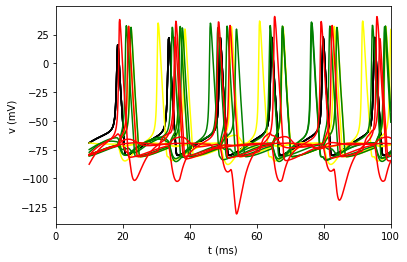

In [5]:
# Record a few traces
trace_EC2 = StateMonitor(EC2, 'v', record=range(5))
trace_DG = StateMonitor(DG, 'v', record=range(5))
trace_CA1 = StateMonitor(CA1, 'v', record=range(5))
trace_CA3 = StateMonitor(CA3, list('vmnh'), record=range(5))
run(.5 * second, report='text')
for trace, color in ((trace_EC2, 'black'), (trace_DG, 'yellow'), (trace_CA1, 'green'), (trace_CA3, 'red')):
    for i in range(5):                              
        plt.plot(trace.t[100:]/ms, trace[i].v[100:]/mV, color=color)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.xlim(0,100)
plt.show()